In [1]:
import sys

# Replace with your path to the cloned repository (/path/to/torchVAE)
root_path = '/cs/cs152/individual/rohan/semisupervisedVAE/'

if root_path not in sys.path:
    sys.path.insert(1, root_path)
    
from models.cpcvae import ConsistencyConstrainedVAE
from utils.vistools import *
from utils.datatools import load_data, EncodedDataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Load trained PCVAE

In [3]:
cpcvae = ConsistencyConstrainedVAE(architecture="fc", latent_dims=50, num_classes=10, input_dims=784, distn="bern")

In [4]:
saved_model = "../checkpoints/test_cpcvae_mnist_agg"

In [5]:
state_dict = torch.load(saved_model)
cpcvae.load_state_dict(state_dict)
cpcvae.eval()
cpcvae.to(device)

ConsistencyConstrainedVAE(
  (encoder): FCEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=50, bias=True)
    (linear4): Linear(in_features=512, out_features=50, bias=True)
  )
  (decoder): FCDecoder(
    (linear1): Linear(in_features=50, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3_mu): Linear(in_features=512, out_features=784, bias=True)
  )
  (classifier): LogisticRegression(
    (linear): Linear(in_features=50, out_features=10, bias=True)
  )
)

### Get data

In [6]:
DATASET_NAME = "MNIST"
NUM_TRAIN = 100
BATCH_SIZE = 128
data_l, data_u, input_size = load_data(DATASET_NAME, NUM_TRAIN)
dataLoader_l = DataLoader(data_l, batch_size=BATCH_SIZE, shuffle=True)
dataLoader_u = DataLoader(data_u, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
def encode(x, device):
    with torch.no_grad():
        cpcvae.encoder.eval()
        x = x.to(device)
        mean, logvar = cpcvae.encoder(x.to(device))
        
        # Sample an image from the distribution
        z = cpcvae.encoder.sample(mean, logvar)
        z = z.detach()
        
        return z
    
encoded_train_data = EncodedDataset(data_l, encode, device)
encoded_val_data = EncodedDataset(data_u, encode, device)
print(f'Encoded train data shape: {encoded_train_data[0][0].shape}')

train_dataLoader = DataLoader(encoded_train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataLoader = DataLoader(encoded_val_data, batch_size=BATCH_SIZE, shuffle=False)


100%|██████████| 69900/69900 [00:32<00:00, 2128.62it/s]

Encoded train data shape: torch.Size([1, 50])


### Compute accuracy of classifier 

In [8]:
def validate(model, dataLoader, device, input_size, loss_fn):
    model.eval()
    accurate = 0
    total = 0
    dl_losses = []

    with torch.no_grad():
        for images,labels in dataLoader:
            images = images.view(-1, input_size).to(device)
            labels = labels.to(device)
    
            output = model(images)
            _,predicted = torch.max(output.data, 1)
    
            # compute loss
            dl_losses.append(loss_fn(output, labels).item())
            
            # total labels
            total += labels.size(0)
            
            # total correct predictions
            accurate += (predicted == labels).sum().item()
    
    accuracy_score = 100 * accurate/total
    return np.mean(dl_losses), accuracy_score

In [9]:
validate(cpcvae.classifier, train_dataLoader, device=device, input_size=50, loss_fn=nn.CrossEntropyLoss())

(0.005255965515971184, 100.0)

In [10]:
validate(cpcvae.classifier, valid_dataLoader, device=device, input_size=50, loss_fn=nn.CrossEntropyLoss())

(1.4888188083821285, 78.0958512160229)

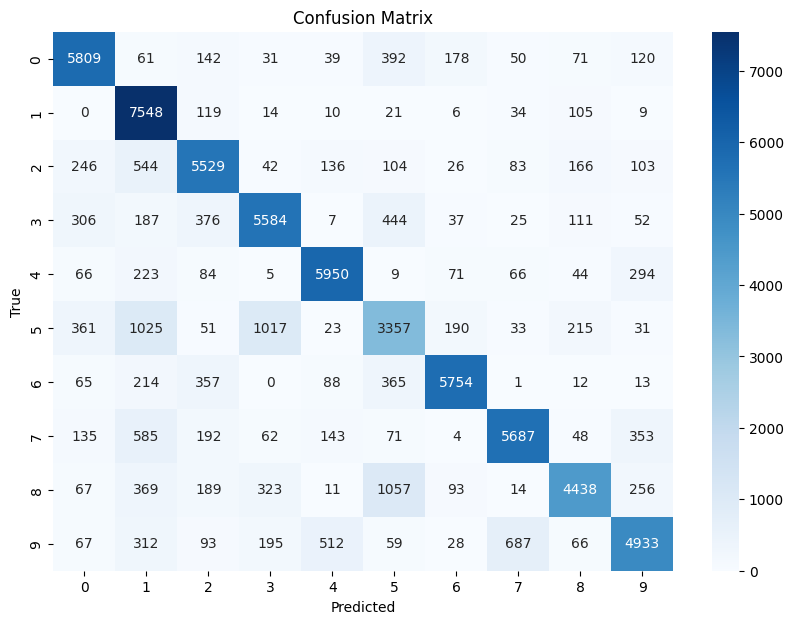

In [11]:
generate_confusion_matrix(cpcvae, valid_dataLoader, device)

### Visualize latent distribution

In [12]:
z_batches, y_batches = get_latent(cpcvae, dataLoader_u, num_batches=100, latent_dims=50, device='cuda')

In [13]:
z_batches.shape

torch.Size([12800, 50])

In [14]:
y_batches.shape

torch.Size([12800])

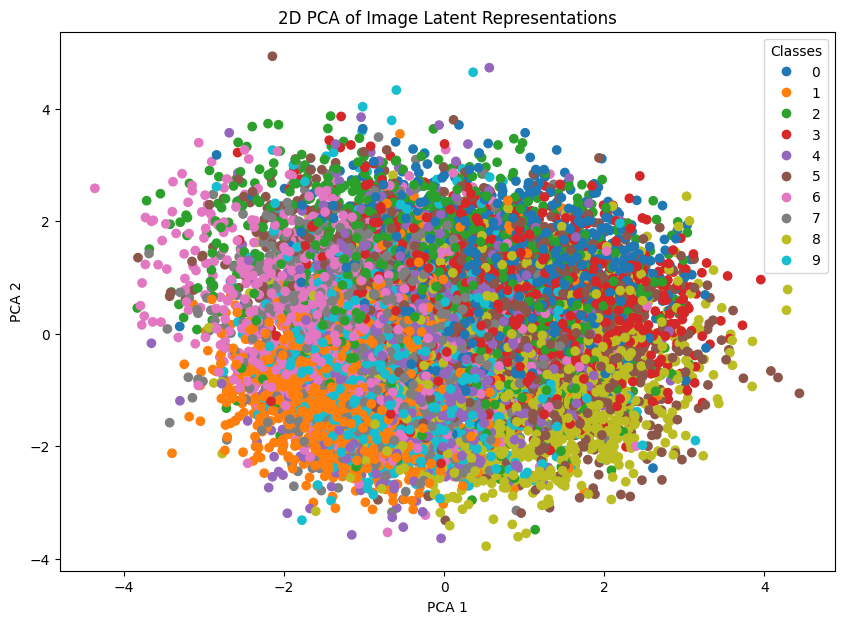

In [15]:
plotPCAdist(z_batches, y_batches)

/cs/cs152/individual/rohan/semisupervisedVAE/utils/vistools.py:105: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


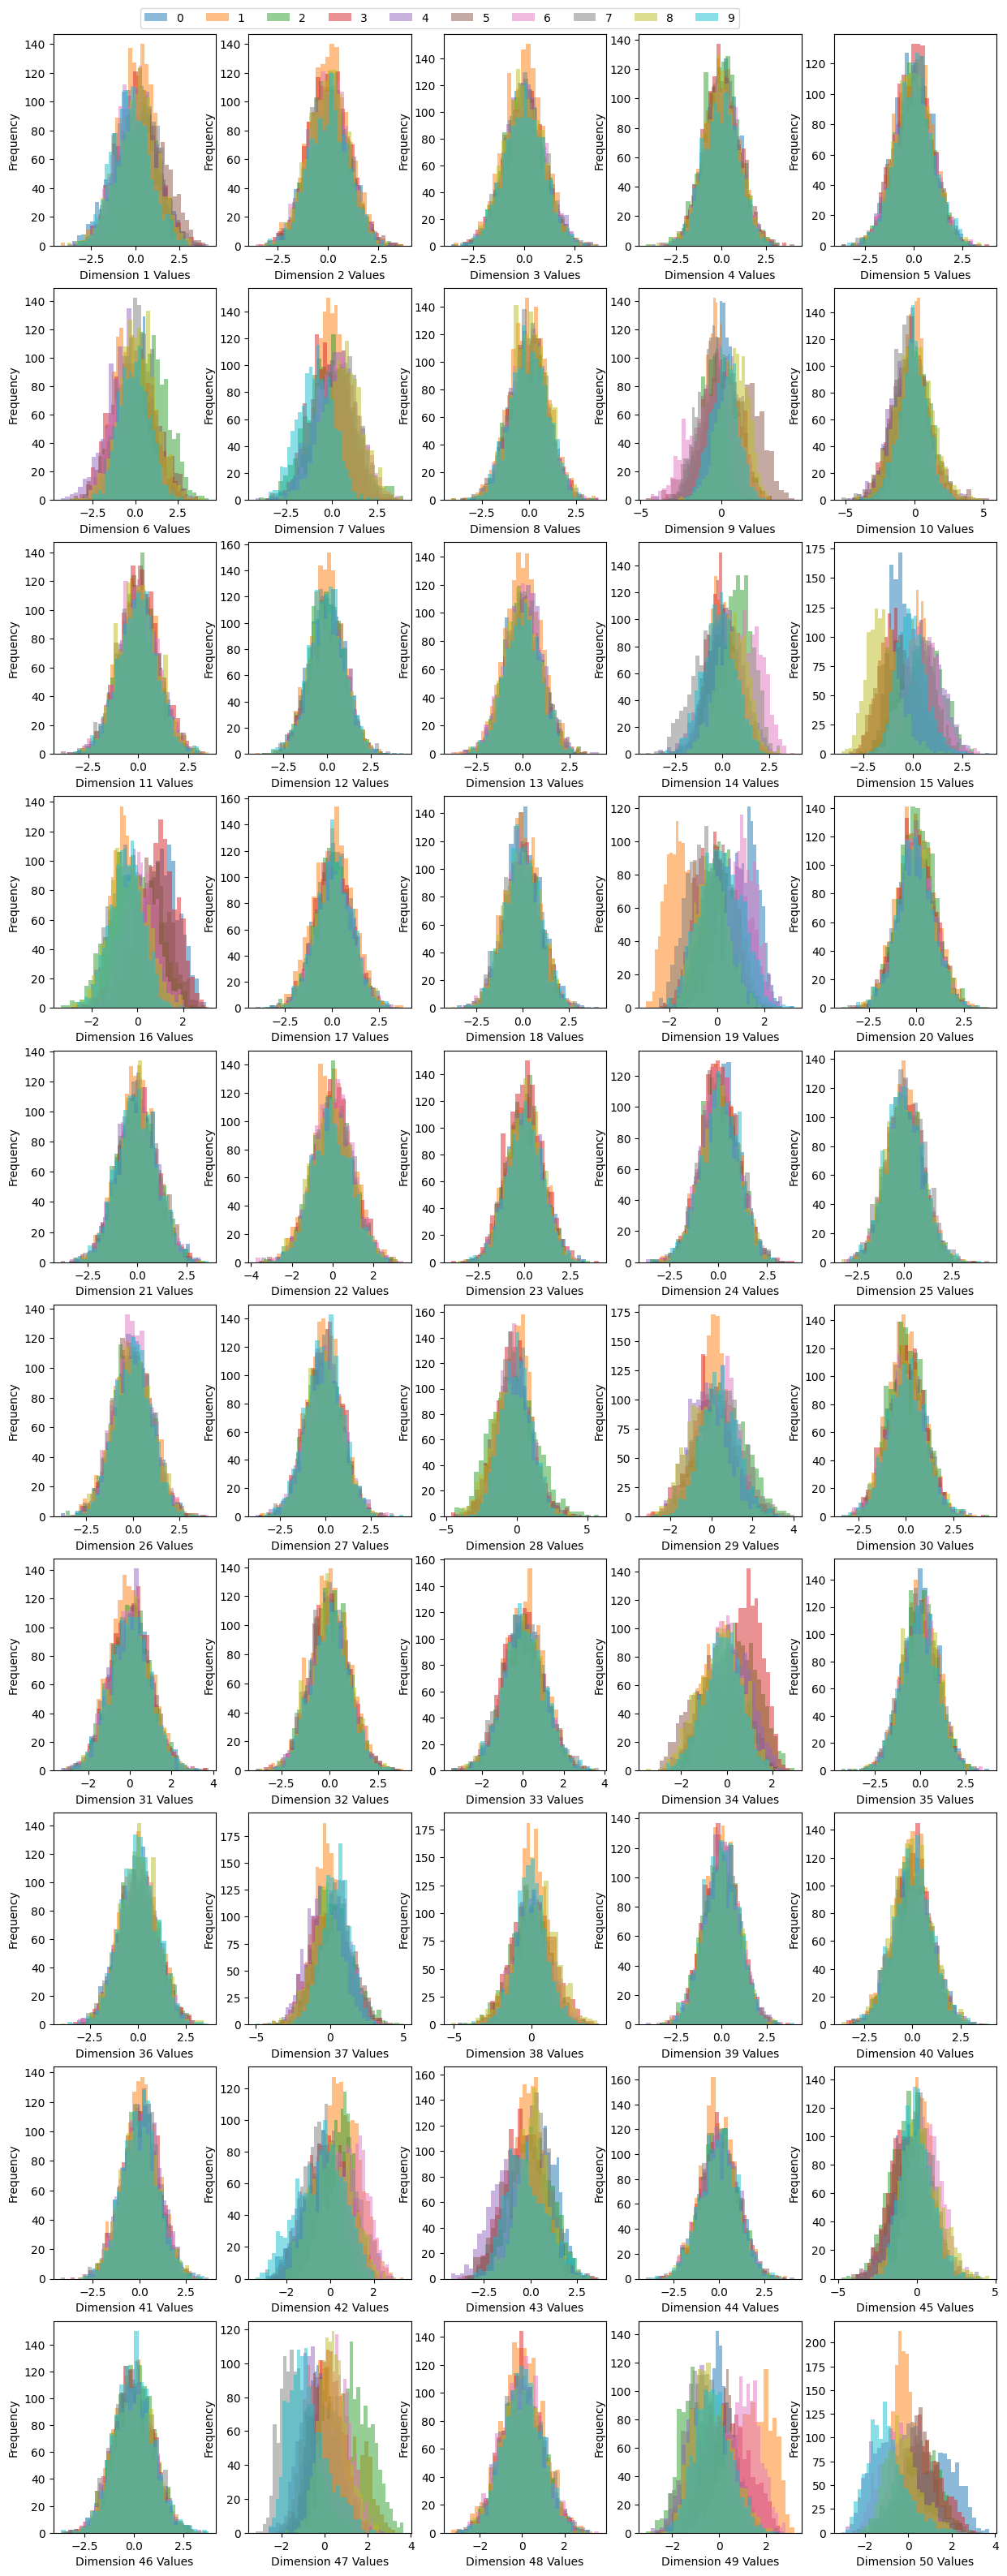

In [16]:
stackedHist(z_batches, y_batches)

### Generate image samples and reconstructions

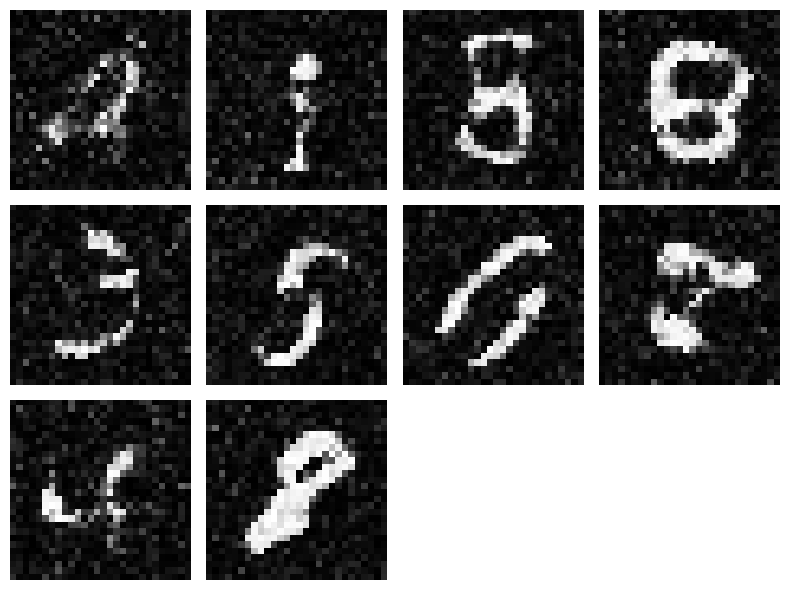

In [17]:
sample_random(cpcvae, n=10)

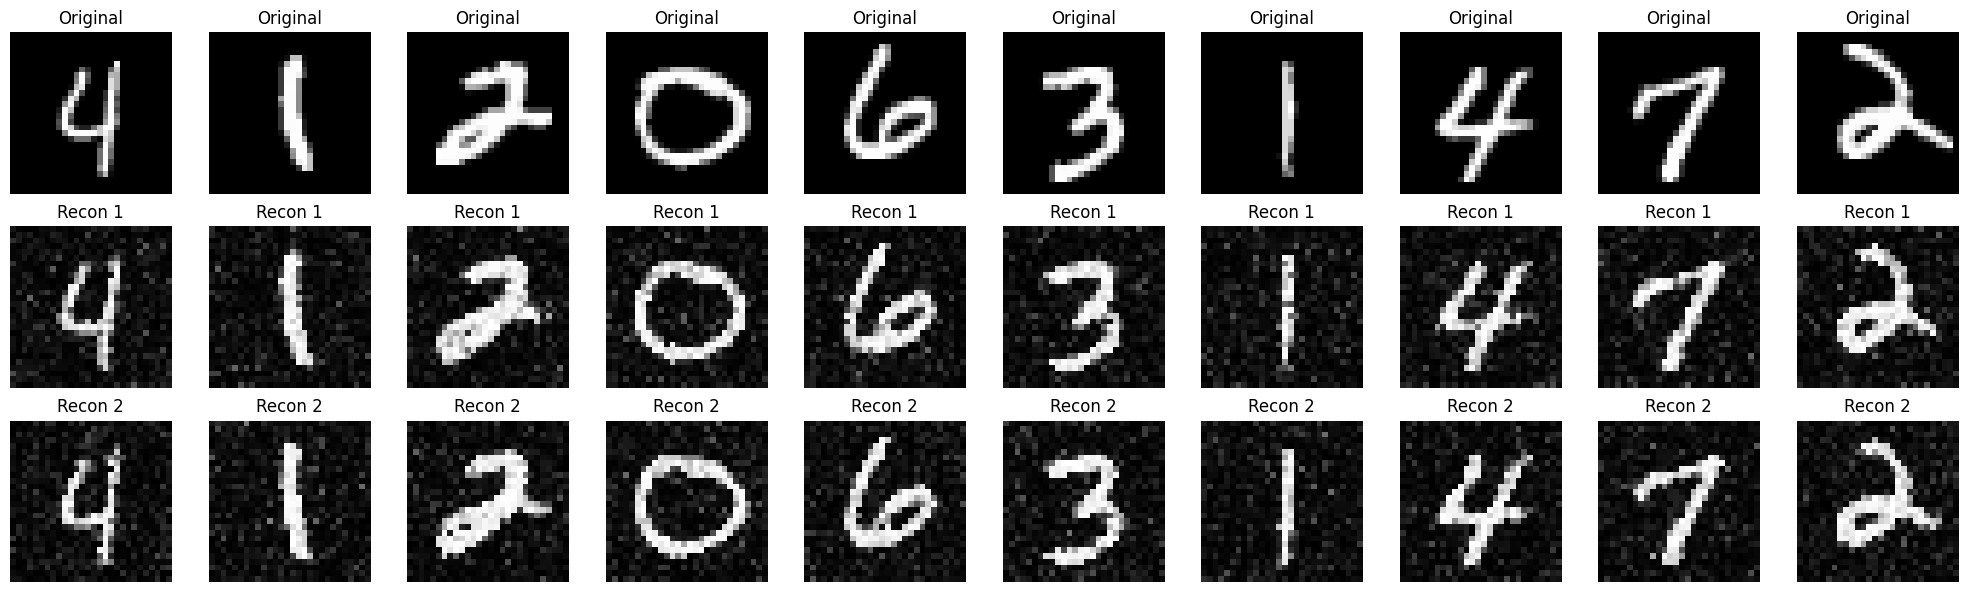

In [18]:
reconstruct_and_compare(cpcvae, dataLoader_u, device, n=10)
